### <span style="color:brown">Notebook Instructions</span>

- <i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the next unit. </b> It will not run in the browser.</i>
- <i>  Assuming, you have Anaconda or some Python environment installed on your system, <span style="color:#FFFF00; background:#00C000"> <b> you need to install Keras library. </b>. </i>
- <i> <span style="color:#00C000"> DNN models are very heavy and it is possible that your code will take time to run. Be patient and try again if required. Keep your CPU free of other burdens during the time of run! </i>
    
#### When running this model on your system, please convert the cells in RawNBConvert format type to Code type, using the dropdown for cell type option present in the menu bar.####


### <span style="color:brown">Notebook Objectives</span>

This notebook contains the code and explanation for performing a GridSearch Cross Vlaidation to arrive at the best DNN model that predicts the trend of a stock. The best predicted model is used to create a trading strategy and its returns are compared with market returns. 

### <span style="color:brown">Data Pre-Processing</span> 

In [1]:
from nsepy import get_history
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

start = date(2015,1,1)
end= date.today()

data = get_history(symbol="SBIN", start=start, end=end)

max_=data[['Open','High','Low','Close']].max().max()
min_=data[['Open','High','Low','Close']].min().min()

scl=MinMaxScaler()

X1=(data[['Open','High','Low','Close']]-min_)/(max_-min_)
X2=scl.fit_transform(data[['Volume']].values.reshape(-1,1))
X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [2]:
data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,SBIN,EQ,311.85,0.808668,0.821226,0.800049,314.0,0.816301,313.67,0.015643,1.925489e+14,58688,1877677,0.3059
2015-01-02,SBIN,EQ,314.00,0.818025,0.837478,0.818025,315.6,0.822458,316.80,0.030211,3.147389e+14,79553,4221685,0.4249
2015-01-05,SBIN,EQ,315.25,0.827382,0.830091,0.806944,312.8,0.810145,313.84,0.027147,2.867432e+14,88236,3845173,0.4208
2015-01-06,SBIN,EQ,312.75,0.796602,0.802019,0.740951,299.9,0.746860,305.14,0.050909,4.677601e+14,169268,7424847,0.4844
2015-01-07,SBIN,EQ,299.90,0.747353,0.759911,0.723467,301.4,0.748092,299.95,0.049825,4.513243e+14,147185,5631400,0.3743


### <span style="color:brown"> Creating the input and target features

In [3]:
X=data[['Open','High','Low','Close','Volume']]
y=np.ones(len(data.Last))
y=np.where(data.Last.shift(-5)>data.Last,1,0) # If the returns are higher, then 'y' is 1, else '0'.

In [4]:
test_size=100
X_train=np.array(X.iloc[:-test_size])
y_train=np.array(y[:-test_size])
X_test=np.array(X.iloc[-test_size:])
y_test=np.array(y[-test_size:])

### <span style="color:brown">Set Class Weights</span>

In [5]:
class_1=y_train.sum()
class_0=len(y_train)-class_1
class_0_percentage=class_0/len(y_train)
class_1_percentage=class_1/len(y_train)

class_0_weight=class_1_percentage
class_1_weight=class_0_percentage

# We will create a dictionary called class_weight to allocate the corresponding weights to each of the labels.
class_weight={0:class_0_weight,1:class_1_weight}

In [6]:
y_train.shape,X_train.shape

((771,), (771, 5))

### <span style="color:brown">Creating the best DNN model</span>

We have three code cells here, which 

- Import the libraries, including the Keras_CV file where the function create_new_model is written.
- Instantiate the KerasClassifier function with inputs: create_new_model function, epochs, batch_size, validation_split, and class_weight.
- Define Hyper Parameters over which you want to train the model (neurons, activations and dropout_ratio)
- Create the parameter grid as a dictinary with keys contianing the inputs of the create_new_model fucntion, and values contianing the hyper-parameters.
- Create a GridSearch object with KerasClassifier instantiation and parameter grid as its input.
- Fit the train data to this GridSearch Object

In [7]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from Keras_CV import create_new_model

np.random.seed(42)

Using TensorFlow backend.


In [8]:
model = KerasClassifier(build_fn=create_new_model, epochs=20, batch_size=128, verbose=2, 
                       validation_split=0.2,class_weight=class_weight)

In [9]:
neurons_params = [ 225,150,175]
act_1_params=['tanh','sigmoid','relu']
dropout_ratio_params=[0.18,0.30,0.23]
param_grid = dict(neurons=neurons_params,act_1=act_1_params,dropout_ratio=dropout_ratio_params)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,verbose=2)

grid_result = grid.fit(X_train, y_train)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] dropout_ratio=0.18, act_1=tanh, neurons=225 .....................


C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.9262 - acc: 0.5085 - val_loss: 0.6712 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5066 - acc: 0.4818 - val_loss: 0.4238 - val_acc: 0.4466
Epoch 3/20
 - 0s - loss: 0.3904 - acc: 0.4793 - val_loss: 0.3847 - val_acc: 0.4466
Epoch 4/20
 - 0s - loss: 0.3973 - acc: 0.4964 - val_loss: 0.3847 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3953 - acc: 0.5255 - val_loss: 0.4298 - val_acc: 0.4466
Epoch 6/20
 - 0s - loss: 0.4089 - acc: 0.5207 - val_loss: 0.4415 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.4433 - acc: 0.4818 - val_loss: 0.4001 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.4047 - acc: 0.4939 - val_loss: 0.3497 - val_acc: 0.5922
Epoch 9/20
 - 0s - loss: 0.3922 - acc: 0.4842 - val_loss: 0.3756 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3975 - acc: 0.5450 - val_loss: 0.3509 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3914 - acc: 0.5304 - val_loss: 0.3607 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.4095 - acc:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 1.0397 - acc: 0.4891 - val_loss: 0.4933 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5689 - acc: 0.4404 - val_loss: 0.7255 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4925 - acc: 0.4891 - val_loss: 0.3685 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.4570 - acc: 0.5255 - val_loss: 0.4760 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.4178 - acc: 0.4842 - val_loss: 0.3656 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3783 - acc: 0.5012 - val_loss: 0.3497 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3798 - acc: 0.5012 - val_loss: 0.3458 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3650 - acc: 0.5304 - val_loss: 0.4122 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.4240 - acc: 0.5158 - val_loss: 0.4044 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3863 - acc: 0.5012 - val_loss: 0.3676 - val_acc: 0.4466
Epoch 11/20
 - 0s - loss: 0.3727 - acc: 0.5061 - val_loss: 0.3745 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3836 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 1.3457 - acc: 0.5231 - val_loss: 0.7823 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.5829 - acc: 0.4891 - val_loss: 0.6359 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4455 - acc: 0.5231 - val_loss: 0.6172 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4620 - acc: 0.4696 - val_loss: 0.3784 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.4298 - acc: 0.5134 - val_loss: 0.5884 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.4252 - acc: 0.5255 - val_loss: 0.6179 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.4322 - acc: 0.4964 - val_loss: 0.3456 - val_acc: 0.4854
Epoch 8/20
 - 0s - loss: 0.3907 - acc: 0.4866 - val_loss: 0.3946 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.3961 - acc: 0.4818 - val_loss: 0.3436 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.4007 - acc: 0.4818 - val_loss: 0.4460 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3966 - acc: 0.5207 - val_loss: 0.3726 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.4068 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.6109 - acc: 0.4793 - val_loss: 0.3468 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4386 - acc: 0.5474 - val_loss: 0.3572 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4121 - acc: 0.4745 - val_loss: 0.4070 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3764 - acc: 0.5061 - val_loss: 0.3445 - val_acc: 0.5534
Epoch 5/20
 - 0s - loss: 0.3728 - acc: 0.5182 - val_loss: 0.3824 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3881 - acc: 0.5207 - val_loss: 0.3453 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3995 - acc: 0.4769 - val_loss: 0.4177 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3829 - acc: 0.5231 - val_loss: 0.3476 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.4095 - acc: 0.5036 - val_loss: 0.4015 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.4049 - acc: 0.5109 - val_loss: 0.5392 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.4202 - acc: 0.5328 - val_loss: 0.4779 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.4456 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.6277 - acc: 0.4866 - val_loss: 0.3494 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4556 - acc: 0.5353 - val_loss: 0.6254 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4096 - acc: 0.5499 - val_loss: 0.5650 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.4322 - acc: 0.5207 - val_loss: 0.4171 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.4215 - acc: 0.5231 - val_loss: 0.3449 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.4103 - acc: 0.4428 - val_loss: 0.3445 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3979 - acc: 0.4964 - val_loss: 0.3569 - val_acc: 0.4466
Epoch 8/20
 - 0s - loss: 0.3852 - acc: 0.4866 - val_loss: 0.4087 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3852 - acc: 0.5134 - val_loss: 0.4622 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3877 - acc: 0.5231 - val_loss: 0.4164 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3840 - acc: 0.5085 - val_loss: 0.3614 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3936 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.6413 - acc: 0.4988 - val_loss: 0.6342 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4832 - acc: 0.4891 - val_loss: 0.3977 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4338 - acc: 0.4988 - val_loss: 0.4302 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4187 - acc: 0.4915 - val_loss: 0.4426 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.4247 - acc: 0.4696 - val_loss: 0.4169 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.3835 - acc: 0.5328 - val_loss: 0.3573 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3751 - acc: 0.5377 - val_loss: 0.3438 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3923 - acc: 0.5231 - val_loss: 0.3499 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.3674 - acc: 0.5377 - val_loss: 0.3695 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3801 - acc: 0.5401 - val_loss: 0.4984 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.4036 - acc: 0.5328 - val_loss: 0.4479 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3865 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.7580 - acc: 0.4307 - val_loss: 0.7836 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5073 - acc: 0.5474 - val_loss: 0.6867 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4628 - acc: 0.5109 - val_loss: 0.5130 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4004 - acc: 0.5304 - val_loss: 0.3921 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3934 - acc: 0.5280 - val_loss: 0.3612 - val_acc: 0.4466
Epoch 6/20
 - 0s - loss: 0.3820 - acc: 0.5085 - val_loss: 0.3566 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3888 - acc: 0.4672 - val_loss: 0.3529 - val_acc: 0.4660
Epoch 8/20
 - 0s - loss: 0.3610 - acc: 0.5499 - val_loss: 0.3752 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3732 - acc: 0.5109 - val_loss: 0.4843 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3933 - acc: 0.5328 - val_loss: 0.3718 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3687 - acc: 0.5693 - val_loss: 0.3625 - val_acc: 0.4466
Epoch 12/20
 - 0s - loss: 0.3702 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 1.0386 - acc: 0.4574 - val_loss: 1.5070 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.8112 - acc: 0.4574 - val_loss: 0.6264 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4672 - acc: 0.4988 - val_loss: 0.4216 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3958 - acc: 0.5134 - val_loss: 0.4031 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3999 - acc: 0.5085 - val_loss: 0.3434 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.4105 - acc: 0.4988 - val_loss: 0.3827 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.4181 - acc: 0.4939 - val_loss: 0.3693 - val_acc: 0.4466
Epoch 8/20
 - 0s - loss: 0.3548 - acc: 0.5620 - val_loss: 0.3472 - val_acc: 0.4563
Epoch 9/20
 - 0s - loss: 0.3759 - acc: 0.4939 - val_loss: 0.3492 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3978 - acc: 0.4672 - val_loss: 0.3867 - val_acc: 0.4466
Epoch 11/20
 - 0s - loss: 0.3766 - acc: 0.4647 - val_loss: 0.3744 - val_acc: 0.4466
Epoch 12/20
 - 0s - loss: 0.3709 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.9589 - acc: 0.5182 - val_loss: 1.3279 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.6572 - acc: 0.4964 - val_loss: 0.6448 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4662 - acc: 0.5061 - val_loss: 0.3711 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4183 - acc: 0.5328 - val_loss: 0.3524 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3916 - acc: 0.5255 - val_loss: 0.3433 - val_acc: 0.6117
Epoch 6/20
 - 0s - loss: 0.4061 - acc: 0.5109 - val_loss: 0.3633 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3713 - acc: 0.5012 - val_loss: 0.4017 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3698 - acc: 0.5353 - val_loss: 0.4120 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3918 - acc: 0.5036 - val_loss: 0.4875 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3920 - acc: 0.4891 - val_loss: 0.3613 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3889 - acc: 0.4842 - val_loss: 0.3486 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3755 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.7764 - acc: 0.5474 - val_loss: 1.7683 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.7441 - acc: 0.5012 - val_loss: 0.9029 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.5025 - acc: 0.5061 - val_loss: 0.3740 - val_acc: 0.4466
Epoch 4/20
 - 0s - loss: 0.4985 - acc: 0.5182 - val_loss: 0.4701 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.5702 - acc: 0.4599 - val_loss: 0.6591 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.5132 - acc: 0.5401 - val_loss: 0.4484 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.4301 - acc: 0.4866 - val_loss: 0.3695 - val_acc: 0.4563
Epoch 8/20
 - 0s - loss: 0.4292 - acc: 0.5231 - val_loss: 0.3543 - val_acc: 0.6117
Epoch 9/20
 - 0s - loss: 0.4140 - acc: 0.4477 - val_loss: 0.3534 - val_acc: 0.4951
Epoch 10/20
 - 0s - loss: 0.4187 - acc: 0.5158 - val_loss: 0.4530 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.4385 - acc: 0.4696 - val_loss: 0.4355 - val_acc: 0.4466
Epoch 12/20
 - 0s - loss: 0.4142 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.4807 - acc: 0.5134 - val_loss: 1.0470 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.6450 - acc: 0.5182 - val_loss: 1.0460 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.5733 - acc: 0.5158 - val_loss: 1.1159 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.5443 - acc: 0.5036 - val_loss: 0.7319 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4373 - acc: 0.5231 - val_loss: 0.4712 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4452 - acc: 0.5061 - val_loss: 0.3474 - val_acc: 0.4660
Epoch 7/20
 - 0s - loss: 0.4534 - acc: 0.5061 - val_loss: 0.3567 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3934 - acc: 0.5280 - val_loss: 0.5279 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.4357 - acc: 0.4866 - val_loss: 0.3910 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.4245 - acc: 0.4866 - val_loss: 0.3539 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.4327 - acc: 0.5012 - val_loss: 0.4235 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.4280 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.5406 - acc: 0.5207 - val_loss: 1.1535 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4897 - acc: 0.5207 - val_loss: 0.3847 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4602 - acc: 0.4891 - val_loss: 0.3671 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4724 - acc: 0.4988 - val_loss: 0.6628 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.4647 - acc: 0.4818 - val_loss: 0.3459 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.4178 - acc: 0.5328 - val_loss: 0.4097 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.4188 - acc: 0.5255 - val_loss: 0.6230 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.4538 - acc: 0.5109 - val_loss: 0.5423 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.4530 - acc: 0.5158 - val_loss: 0.5061 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.4745 - acc: 0.4915 - val_loss: 0.4060 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3910 - acc: 0.5426 - val_loss: 0.3588 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3834 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.4507 - acc: 0.5061 - val_loss: 0.3672 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4705 - acc: 0.4891 - val_loss: 0.4175 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4348 - acc: 0.4793 - val_loss: 0.6659 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4392 - acc: 0.5499 - val_loss: 0.6072 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4457 - acc: 0.5012 - val_loss: 0.5928 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4227 - acc: 0.5450 - val_loss: 0.4057 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.4251 - acc: 0.5085 - val_loss: 0.4441 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3910 - acc: 0.5645 - val_loss: 0.5172 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.4058 - acc: 0.5182 - val_loss: 0.3944 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3993 - acc: 0.5061 - val_loss: 0.3455 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3831 - acc: 0.5401 - val_loss: 0.3571 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.4060 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.4561 - acc: 0.5012 - val_loss: 0.5518 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4282 - acc: 0.5572 - val_loss: 0.5569 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4532 - acc: 0.4915 - val_loss: 0.4829 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4338 - acc: 0.4988 - val_loss: 0.3718 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4359 - acc: 0.4599 - val_loss: 0.4853 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4292 - acc: 0.4769 - val_loss: 0.3603 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3898 - acc: 0.5280 - val_loss: 0.3904 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3770 - acc: 0.5547 - val_loss: 0.3498 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.4036 - acc: 0.5158 - val_loss: 0.3576 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.4458 - acc: 0.5207 - val_loss: 0.4497 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.4167 - acc: 0.5036 - val_loss: 0.3439 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3755 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.5214 - acc: 0.5061 - val_loss: 0.9758 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.5431 - acc: 0.4842 - val_loss: 0.4955 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.4682 - acc: 0.4623 - val_loss: 0.5126 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.4324 - acc: 0.5061 - val_loss: 0.5718 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.4156 - acc: 0.5109 - val_loss: 0.5081 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.4229 - acc: 0.4623 - val_loss: 0.4008 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3844 - acc: 0.5353 - val_loss: 0.3487 - val_acc: 0.4951
Epoch 8/20
 - 0s - loss: 0.4221 - acc: 0.4209 - val_loss: 0.3655 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.4224 - acc: 0.4745 - val_loss: 0.3838 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3735 - acc: 0.5596 - val_loss: 0.3516 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.4085 - acc: 0.4964 - val_loss: 0.3436 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.4121 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.6077 - acc: 0.4891 - val_loss: 0.6094 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4988 - acc: 0.5036 - val_loss: 0.3494 - val_acc: 0.4854
Epoch 3/20
 - 0s - loss: 0.4365 - acc: 0.5158 - val_loss: 0.3496 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.4070 - acc: 0.5620 - val_loss: 0.3642 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.4192 - acc: 0.4988 - val_loss: 0.3658 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4436 - acc: 0.5280 - val_loss: 0.3763 - val_acc: 0.5534
Epoch 7/20
 - 0s - loss: 0.4256 - acc: 0.5109 - val_loss: 0.4651 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.4442 - acc: 0.5134 - val_loss: 0.4117 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.4085 - acc: 0.4915 - val_loss: 0.4234 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3884 - acc: 0.5401 - val_loss: 0.3449 - val_acc: 0.4951
Epoch 11/20
 - 0s - loss: 0.3853 - acc: 0.5474 - val_loss: 0.3500 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3751 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.5185 - acc: 0.5012 - val_loss: 0.5617 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4887 - acc: 0.4818 - val_loss: 0.3779 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4986 - acc: 0.5036 - val_loss: 0.6565 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4552 - acc: 0.4793 - val_loss: 0.4647 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4452 - acc: 0.4866 - val_loss: 0.3748 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4280 - acc: 0.4988 - val_loss: 0.4571 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.4043 - acc: 0.5182 - val_loss: 0.3490 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.4031 - acc: 0.5158 - val_loss: 0.4376 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3989 - acc: 0.5328 - val_loss: 0.3480 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.4034 - acc: 0.5061 - val_loss: 0.3426 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3977 - acc: 0.5401 - val_loss: 0.3504 - val_acc: 0.4466
Epoch 12/20
 - 0s - loss: 0.4194 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.5866 - acc: 0.4793 - val_loss: 0.9917 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.5715 - acc: 0.4964 - val_loss: 0.3993 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.4576 - acc: 0.5109 - val_loss: 0.3640 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.4219 - acc: 0.5231 - val_loss: 0.3451 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.4356 - acc: 0.4672 - val_loss: 0.3411 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3868 - acc: 0.5377 - val_loss: 0.3438 - val_acc: 0.4951
Epoch 7/20
 - 0s - loss: 0.4110 - acc: 0.4769 - val_loss: 0.3656 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.4062 - acc: 0.4842 - val_loss: 0.3736 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.4073 - acc: 0.4793 - val_loss: 0.3473 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.4122 - acc: 0.4647 - val_loss: 0.3570 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.4134 - acc: 0.4988 - val_loss: 0.3465 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3913 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 1s - loss: 0.9773 - acc: 0.4939 - val_loss: 0.9385 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5943 - acc: 0.5255 - val_loss: 0.9323 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.5222 - acc: 0.5280 - val_loss: 0.4853 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4204 - acc: 0.5304 - val_loss: 0.4255 - val_acc: 0.4466
Epoch 5/20
 - 0s - loss: 0.4224 - acc: 0.5401 - val_loss: 0.5319 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.4313 - acc: 0.4842 - val_loss: 0.3694 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.4269 - acc: 0.4915 - val_loss: 0.4491 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.4194 - acc: 0.4599 - val_loss: 0.3743 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3912 - acc: 0.4988 - val_loss: 0.6567 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.4392 - acc: 0.5158 - val_loss: 0.3502 - val_acc: 0.4854
Epoch 11/20
 - 0s - loss: 0.4140 - acc: 0.5134 - val_loss: 0.3472 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3834 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.8354 - acc: 0.5255 - val_loss: 1.2521 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.7482 - acc: 0.5036 - val_loss: 0.9393 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.5007 - acc: 0.5280 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.4730 - acc: 0.4891 - val_loss: 0.3921 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4215 - acc: 0.4915 - val_loss: 0.3735 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4069 - acc: 0.4647 - val_loss: 0.3426 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3975 - acc: 0.4939 - val_loss: 0.3438 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3743 - acc: 0.5134 - val_loss: 0.3560 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3793 - acc: 0.5280 - val_loss: 0.3582 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.4040 - acc: 0.4769 - val_loss: 0.3793 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.4082 - acc: 0.5012 - val_loss: 0.3901 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.4253 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.9152 - acc: 0.4842 - val_loss: 1.7906 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.8741 - acc: 0.4891 - val_loss: 0.3975 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.6364 - acc: 0.4672 - val_loss: 0.6586 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.5473 - acc: 0.4793 - val_loss: 0.5364 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.4432 - acc: 0.5182 - val_loss: 0.5502 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.4299 - acc: 0.4818 - val_loss: 0.4412 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.4201 - acc: 0.4696 - val_loss: 0.3616 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3845 - acc: 0.4988 - val_loss: 0.3773 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.4131 - acc: 0.4939 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3924 - acc: 0.5109 - val_loss: 0.3891 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3980 - acc: 0.4915 - val_loss: 0.6663 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.4159 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.6031 - acc: 0.4404 - val_loss: 0.5862 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.5291 - acc: 0.4599 - val_loss: 0.3438 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4100 - acc: 0.4842 - val_loss: 0.3470 - val_acc: 0.4854
Epoch 4/20
 - 0s - loss: 0.3920 - acc: 0.5669 - val_loss: 0.3556 - val_acc: 0.4854
Epoch 5/20
 - 0s - loss: 0.3846 - acc: 0.5158 - val_loss: 0.3574 - val_acc: 0.5534
Epoch 6/20
 - 0s - loss: 0.3896 - acc: 0.4939 - val_loss: 0.3465 - val_acc: 0.5340
Epoch 7/20
 - 0s - loss: 0.3880 - acc: 0.5085 - val_loss: 0.3654 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3734 - acc: 0.5401 - val_loss: 0.3456 - val_acc: 0.4854
Epoch 9/20
 - 0s - loss: 0.3845 - acc: 0.4891 - val_loss: 0.4258 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3929 - acc: 0.5134 - val_loss: 0.3444 - val_acc: 0.5049
Epoch 11/20
 - 0s - loss: 0.3792 - acc: 0.5304 - val_loss: 0.3516 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3963 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.6363 - acc: 0.5061 - val_loss: 1.4298 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.6710 - acc: 0.4696 - val_loss: 0.8660 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.5027 - acc: 0.5085 - val_loss: 0.5385 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4247 - acc: 0.4793 - val_loss: 0.4711 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4152 - acc: 0.5036 - val_loss: 0.5417 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4303 - acc: 0.4623 - val_loss: 0.3756 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3941 - acc: 0.4988 - val_loss: 0.3695 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3998 - acc: 0.4793 - val_loss: 0.3441 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3725 - acc: 0.5182 - val_loss: 0.3440 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3959 - acc: 0.4964 - val_loss: 0.3740 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3806 - acc: 0.5207 - val_loss: 0.4489 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.4453 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.5609 - acc: 0.4647 - val_loss: 0.5241 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4802 - acc: 0.4891 - val_loss: 0.7743 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.4825 - acc: 0.4793 - val_loss: 0.4275 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.3965 - acc: 0.5085 - val_loss: 0.3696 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3896 - acc: 0.5280 - val_loss: 0.3444 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3944 - acc: 0.4842 - val_loss: 0.4578 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3960 - acc: 0.5231 - val_loss: 0.4152 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3993 - acc: 0.5085 - val_loss: 0.4639 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.3967 - acc: 0.4964 - val_loss: 0.3429 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3819 - acc: 0.5280 - val_loss: 0.3621 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3856 - acc: 0.5061 - val_loss: 0.3531 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.4013 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.5905 - acc: 0.5231 - val_loss: 0.4427 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.3921 - acc: 0.5791 - val_loss: 0.4172 - val_acc: 0.5534
Epoch 3/20
 - 0s - loss: 0.4114 - acc: 0.5304 - val_loss: 0.3539 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.4040 - acc: 0.4599 - val_loss: 0.3780 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3929 - acc: 0.5012 - val_loss: 0.4880 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3959 - acc: 0.5280 - val_loss: 0.3615 - val_acc: 0.4563
Epoch 7/20
 - 0s - loss: 0.3898 - acc: 0.5109 - val_loss: 0.4343 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.4179 - acc: 0.5036 - val_loss: 0.4258 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.4036 - acc: 0.4818 - val_loss: 0.4722 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.4219 - acc: 0.5061 - val_loss: 0.3434 - val_acc: 0.5728
Epoch 11/20
 - 0s - loss: 0.4070 - acc: 0.5061 - val_loss: 0.3643 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3900 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.6511 - acc: 0.5231 - val_loss: 0.5032 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5057 - acc: 0.5012 - val_loss: 0.9442 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.5730 - acc: 0.4866 - val_loss: 0.9070 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.5937 - acc: 0.5134 - val_loss: 0.7276 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.4743 - acc: 0.5036 - val_loss: 0.5363 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.4525 - acc: 0.5158 - val_loss: 0.5188 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.4169 - acc: 0.4964 - val_loss: 0.4388 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.4348 - acc: 0.4964 - val_loss: 0.4663 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3984 - acc: 0.4769 - val_loss: 0.4020 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3812 - acc: 0.5353 - val_loss: 0.3528 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3734 - acc: 0.5061 - val_loss: 0.3522 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3778 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.6947 - acc: 0.4769 - val_loss: 0.9005 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4924 - acc: 0.5109 - val_loss: 0.5092 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4820 - acc: 0.4501 - val_loss: 0.4671 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.4828 - acc: 0.4672 - val_loss: 0.4652 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.4172 - acc: 0.5231 - val_loss: 0.6022 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.4444 - acc: 0.4672 - val_loss: 0.3615 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3854 - acc: 0.5426 - val_loss: 0.3925 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3860 - acc: 0.4939 - val_loss: 0.3659 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.3823 - acc: 0.5134 - val_loss: 0.3593 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3895 - acc: 0.4915 - val_loss: 0.3576 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3912 - acc: 0.5158 - val_loss: 0.3417 - val_acc: 0.5340
Epoch 12/20
 - 0s - loss: 0.3798 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.4976 - acc: 0.5499 - val_loss: 0.4950 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4638 - acc: 0.4769 - val_loss: 0.5417 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3971 - acc: 0.5255 - val_loss: 0.3713 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.4069 - acc: 0.4574 - val_loss: 0.3750 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3708 - acc: 0.5328 - val_loss: 0.3813 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3526 - acc: 0.5231 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3525 - acc: 0.5012 - val_loss: 0.3653 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3597 - acc: 0.5109 - val_loss: 0.3625 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3564 - acc: 0.4866 - val_loss: 0.3439 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3532 - acc: 0.4988 - val_loss: 0.3597 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3517 - acc: 0.5377 - val_loss: 0.3626 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3493 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.5348 - acc: 0.5109 - val_loss: 0.5511 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4231 - acc: 0.4964 - val_loss: 0.4460 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4262 - acc: 0.5255 - val_loss: 0.4056 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4376 - acc: 0.4818 - val_loss: 0.3485 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3921 - acc: 0.4769 - val_loss: 0.3823 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3938 - acc: 0.4866 - val_loss: 0.3786 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3747 - acc: 0.4891 - val_loss: 0.3476 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3599 - acc: 0.4915 - val_loss: 0.3469 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3659 - acc: 0.4866 - val_loss: 0.3520 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3586 - acc: 0.4866 - val_loss: 0.3605 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3538 - acc: 0.5012 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3585 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.5967 - acc: 0.4720 - val_loss: 0.7265 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4974 - acc: 0.5085 - val_loss: 0.5022 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.5075 - acc: 0.4915 - val_loss: 0.3549 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.3951 - acc: 0.5085 - val_loss: 0.4041 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3711 - acc: 0.4915 - val_loss: 0.3658 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3830 - acc: 0.4866 - val_loss: 0.3461 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3754 - acc: 0.4574 - val_loss: 0.3732 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3547 - acc: 0.5061 - val_loss: 0.3494 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3680 - acc: 0.4672 - val_loss: 0.3468 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3541 - acc: 0.4842 - val_loss: 0.3589 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3555 - acc: 0.4891 - val_loss: 0.3498 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3433 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.3881 - acc: 0.5426 - val_loss: 0.3656 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.3809 - acc: 0.5134 - val_loss: 0.4559 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3898 - acc: 0.4939 - val_loss: 0.3434 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3610 - acc: 0.4793 - val_loss: 0.3858 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3691 - acc: 0.4964 - val_loss: 0.3427 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3537 - acc: 0.5036 - val_loss: 0.3854 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3665 - acc: 0.5255 - val_loss: 0.3503 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3592 - acc: 0.4793 - val_loss: 0.3445 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3481 - acc: 0.5158 - val_loss: 0.3691 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3558 - acc: 0.5231 - val_loss: 0.3450 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3620 - acc: 0.4501 - val_loss: 0.3459 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3475 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.4488 - acc: 0.5134 - val_loss: 0.6170 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4729 - acc: 0.4988 - val_loss: 0.4108 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4465 - acc: 0.5255 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3997 - acc: 0.4501 - val_loss: 0.4050 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3624 - acc: 0.5401 - val_loss: 0.3507 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3674 - acc: 0.5353 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3559 - acc: 0.4818 - val_loss: 0.3711 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3719 - acc: 0.4647 - val_loss: 0.3469 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3587 - acc: 0.4550 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3572 - acc: 0.5085 - val_loss: 0.3460 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3523 - acc: 0.5109 - val_loss: 0.3522 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3534 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.3738 - acc: 0.5109 - val_loss: 0.3762 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.3680 - acc: 0.4988 - val_loss: 0.3483 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.3573 - acc: 0.4842 - val_loss: 0.3548 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.3610 - acc: 0.4720 - val_loss: 0.3465 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3542 - acc: 0.5207 - val_loss: 0.3600 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.3606 - acc: 0.5231 - val_loss: 0.3544 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3785 - acc: 0.4574 - val_loss: 0.3621 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3631 - acc: 0.5182 - val_loss: 0.3541 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3825 - acc: 0.4866 - val_loss: 0.3582 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3709 - acc: 0.5085 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3766 - acc: 0.4891 - val_loss: 0.3517 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3538 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.4174 - acc: 0.5450 - val_loss: 0.3573 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.3608 - acc: 0.5353 - val_loss: 0.4749 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3919 - acc: 0.5085 - val_loss: 0.3427 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3575 - acc: 0.4818 - val_loss: 0.3878 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3566 - acc: 0.5231 - val_loss: 0.3449 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3570 - acc: 0.5036 - val_loss: 0.3630 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3550 - acc: 0.5036 - val_loss: 0.3465 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3548 - acc: 0.5036 - val_loss: 0.3578 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3545 - acc: 0.4793 - val_loss: 0.3439 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3491 - acc: 0.5255 - val_loss: 0.3811 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3585 - acc: 0.5280 - val_loss: 0.3460 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3585 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.4468 - acc: 0.5085 - val_loss: 0.6073 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4492 - acc: 0.4866 - val_loss: 0.4365 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4252 - acc: 0.5061 - val_loss: 0.3854 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3923 - acc: 0.4672 - val_loss: 0.3457 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3514 - acc: 0.5036 - val_loss: 0.3442 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3559 - acc: 0.5231 - val_loss: 0.3609 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3607 - acc: 0.5036 - val_loss: 0.3427 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3560 - acc: 0.5255 - val_loss: 0.3428 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3542 - acc: 0.5061 - val_loss: 0.3615 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3559 - acc: 0.4915 - val_loss: 0.3442 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3635 - acc: 0.5061 - val_loss: 0.3427 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3578 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.3978 - acc: 0.5182 - val_loss: 0.4209 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4073 - acc: 0.5255 - val_loss: 0.3892 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.3974 - acc: 0.4477 - val_loss: 0.3643 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.3797 - acc: 0.4623 - val_loss: 0.3837 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3673 - acc: 0.4842 - val_loss: 0.3490 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3611 - acc: 0.4793 - val_loss: 0.3544 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3638 - acc: 0.4866 - val_loss: 0.3463 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3624 - acc: 0.4769 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3482 - acc: 0.5328 - val_loss: 0.3511 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3602 - acc: 0.4964 - val_loss: 0.3475 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3550 - acc: 0.5304 - val_loss: 0.3482 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3549 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.4533 - acc: 0.4526 - val_loss: 0.4600 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4677 - acc: 0.5377 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4048 - acc: 0.5036 - val_loss: 0.3535 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3820 - acc: 0.5377 - val_loss: 0.4053 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3586 - acc: 0.5450 - val_loss: 0.3452 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3668 - acc: 0.4769 - val_loss: 0.3884 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3755 - acc: 0.4964 - val_loss: 0.3491 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3562 - acc: 0.5061 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3604 - acc: 0.4939 - val_loss: 0.3518 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3481 - acc: 0.5450 - val_loss: 0.3589 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3498 - acc: 0.5547 - val_loss: 0.3507 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3520 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 2s - loss: 0.4591 - acc: 0.5182 - val_loss: 0.5698 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4747 - acc: 0.5061 - val_loss: 0.4810 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4208 - acc: 0.4623 - val_loss: 0.3990 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3959 - acc: 0.5182 - val_loss: 0.3973 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3747 - acc: 0.4939 - val_loss: 0.3440 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3736 - acc: 0.5207 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3611 - acc: 0.4842 - val_loss: 0.3624 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3694 - acc: 0.4720 - val_loss: 0.3428 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3602 - acc: 0.5134 - val_loss: 0.3468 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3586 - acc: 0.5255 - val_loss: 0.3537 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3745 - acc: 0.4574 - val_loss: 0.3445 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3660 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.5457 - acc: 0.4915 - val_loss: 0.6928 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.6189 - acc: 0.4842 - val_loss: 0.4868 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.5016 - acc: 0.5085 - val_loss: 0.3540 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4025 - acc: 0.5109 - val_loss: 0.3951 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3936 - acc: 0.4964 - val_loss: 0.3686 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.3883 - acc: 0.5036 - val_loss: 0.3535 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3574 - acc: 0.5061 - val_loss: 0.3560 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3715 - acc: 0.4793 - val_loss: 0.3463 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3602 - acc: 0.4915 - val_loss: 0.3541 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3649 - acc: 0.5036 - val_loss: 0.3477 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3539 - acc: 0.5036 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3581 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4526 - acc: 0.4842 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.3822 - acc: 0.4647 - val_loss: 0.4060 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3779 - acc: 0.5134 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3813 - acc: 0.4720 - val_loss: 0.3578 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3831 - acc: 0.4964 - val_loss: 0.3823 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3682 - acc: 0.4939 - val_loss: 0.3435 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3850 - acc: 0.4769 - val_loss: 0.3878 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3692 - acc: 0.5255 - val_loss: 0.3498 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3781 - acc: 0.4842 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3621 - acc: 0.5255 - val_loss: 0.3903 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3690 - acc: 0.5061 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3803 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.3580 - acc: 0.5328 - val_loss: 0.3525 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.3813 - acc: 0.4647 - val_loss: 0.3582 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.3829 - acc: 0.5085 - val_loss: 0.3973 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3933 - acc: 0.4720 - val_loss: 0.3754 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4005 - acc: 0.5255 - val_loss: 0.3579 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3764 - acc: 0.4647 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3794 - acc: 0.5036 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3703 - acc: 0.4647 - val_loss: 0.3527 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3745 - acc: 0.4672 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3592 - acc: 0.5134 - val_loss: 0.3573 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3710 - acc: 0.4745 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3567 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4278 - acc: 0.4818 - val_loss: 0.5003 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4453 - acc: 0.5085 - val_loss: 0.3807 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4096 - acc: 0.4915 - val_loss: 0.3491 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4011 - acc: 0.4939 - val_loss: 0.3690 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3715 - acc: 0.4866 - val_loss: 0.3731 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3725 - acc: 0.5109 - val_loss: 0.3609 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3663 - acc: 0.5036 - val_loss: 0.3534 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3552 - acc: 0.4915 - val_loss: 0.3523 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3673 - acc: 0.5134 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3638 - acc: 0.5109 - val_loss: 0.3789 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3697 - acc: 0.4988 - val_loss: 0.3465 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3793 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4051 - acc: 0.5280 - val_loss: 0.5145 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4196 - acc: 0.5207 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.3695 - acc: 0.5207 - val_loss: 0.4052 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3805 - acc: 0.4939 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3646 - acc: 0.5012 - val_loss: 0.3826 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3474 - acc: 0.5693 - val_loss: 0.3465 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3851 - acc: 0.4453 - val_loss: 0.3811 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3755 - acc: 0.5596 - val_loss: 0.3555 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3546 - acc: 0.5523 - val_loss: 0.3439 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3592 - acc: 0.5280 - val_loss: 0.3813 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3692 - acc: 0.5158 - val_loss: 0.3441 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3595 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4045 - acc: 0.5353 - val_loss: 0.3698 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.3828 - acc: 0.4964 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.3788 - acc: 0.4842 - val_loss: 0.3453 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3780 - acc: 0.5596 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3509 - acc: 0.5353 - val_loss: 0.3573 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3772 - acc: 0.4526 - val_loss: 0.3536 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3847 - acc: 0.5158 - val_loss: 0.3703 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.4074 - acc: 0.4599 - val_loss: 0.3450 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3740 - acc: 0.4964 - val_loss: 0.3483 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3680 - acc: 0.4915 - val_loss: 0.3653 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3647 - acc: 0.4842 - val_loss: 0.3467 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3741 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4518 - acc: 0.4793 - val_loss: 0.4398 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4003 - acc: 0.5036 - val_loss: 0.4878 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.4027 - acc: 0.5328 - val_loss: 0.3875 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.4243 - acc: 0.4842 - val_loss: 0.3466 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3950 - acc: 0.4501 - val_loss: 0.3870 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.3764 - acc: 0.5061 - val_loss: 0.3532 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3698 - acc: 0.4842 - val_loss: 0.3504 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3567 - acc: 0.5377 - val_loss: 0.3505 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.3643 - acc: 0.4939 - val_loss: 0.3478 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3487 - acc: 0.5401 - val_loss: 0.3582 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3644 - acc: 0.5012 - val_loss: 0.3520 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3657 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4540 - acc: 0.4769 - val_loss: 0.3545 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.3745 - acc: 0.5109 - val_loss: 0.3759 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3783 - acc: 0.4477 - val_loss: 0.3508 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3644 - acc: 0.4769 - val_loss: 0.3670 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3605 - acc: 0.5012 - val_loss: 0.3443 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3739 - acc: 0.4745 - val_loss: 0.4036 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3615 - acc: 0.5474 - val_loss: 0.3512 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3825 - acc: 0.4939 - val_loss: 0.3781 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3642 - acc: 0.4915 - val_loss: 0.3461 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3720 - acc: 0.4818 - val_loss: 0.3508 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3709 - acc: 0.4720 - val_loss: 0.3456 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3495 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.5299 - acc: 0.5231 - val_loss: 0.7189 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4915 - acc: 0.4939 - val_loss: 0.4966 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4602 - acc: 0.5207 - val_loss: 0.4371 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4290 - acc: 0.4745 - val_loss: 0.3462 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3616 - acc: 0.5377 - val_loss: 0.3712 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3866 - acc: 0.5109 - val_loss: 0.3523 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3736 - acc: 0.4842 - val_loss: 0.3482 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3581 - acc: 0.5134 - val_loss: 0.3444 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3546 - acc: 0.5109 - val_loss: 0.3622 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3579 - acc: 0.4915 - val_loss: 0.3450 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3560 - acc: 0.5036 - val_loss: 0.3444 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3588 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.5257 - acc: 0.5061 - val_loss: 0.6829 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4790 - acc: 0.5109 - val_loss: 0.4984 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4398 - acc: 0.4818 - val_loss: 0.4329 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4077 - acc: 0.5061 - val_loss: 0.3462 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3953 - acc: 0.4672 - val_loss: 0.3590 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3732 - acc: 0.4769 - val_loss: 0.3910 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3687 - acc: 0.5231 - val_loss: 0.3462 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3702 - acc: 0.4696 - val_loss: 0.3520 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3572 - acc: 0.5280 - val_loss: 0.3649 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3750 - acc: 0.4818 - val_loss: 0.3559 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3513 - acc: 0.5231 - val_loss: 0.3539 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3724 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.4020 - acc: 0.5280 - val_loss: 0.3502 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.3772 - acc: 0.4891 - val_loss: 0.4023 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3659 - acc: 0.5012 - val_loss: 0.3429 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3755 - acc: 0.4355 - val_loss: 0.3646 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3543 - acc: 0.5231 - val_loss: 0.3434 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3730 - acc: 0.4891 - val_loss: 0.3898 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3826 - acc: 0.5328 - val_loss: 0.3548 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3920 - acc: 0.4307 - val_loss: 0.3447 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3739 - acc: 0.4720 - val_loss: 0.4180 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3539 - acc: 0.5596 - val_loss: 0.3442 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3744 - acc: 0.4647 - val_loss: 0.3677 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3659 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4132 - acc: 0.4939 - val_loss: 0.3650 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.3742 - acc: 0.4818 - val_loss: 0.3821 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3700 - acc: 0.4939 - val_loss: 0.3590 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3754 - acc: 0.5328 - val_loss: 0.3966 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.4019 - acc: 0.4574 - val_loss: 0.3468 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3766 - acc: 0.4891 - val_loss: 0.3461 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3507 - acc: 0.5401 - val_loss: 0.3590 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3601 - acc: 0.4988 - val_loss: 0.3429 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3715 - acc: 0.5255 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3493 - acc: 0.5255 - val_loss: 0.3822 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3754 - acc: 0.4818 - val_loss: 0.3448 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3634 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4046 - acc: 0.4672 - val_loss: 0.3463 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.3680 - acc: 0.5231 - val_loss: 0.3504 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.3839 - acc: 0.4550 - val_loss: 0.3461 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.3729 - acc: 0.4939 - val_loss: 0.3632 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3681 - acc: 0.4818 - val_loss: 0.3558 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3661 - acc: 0.5061 - val_loss: 0.3663 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3673 - acc: 0.5134 - val_loss: 0.3462 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3760 - acc: 0.4842 - val_loss: 0.3474 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3669 - acc: 0.4915 - val_loss: 0.3767 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3674 - acc: 0.4964 - val_loss: 0.3478 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3644 - acc: 0.4696 - val_loss: 0.3471 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3531 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4370 - acc: 0.5134 - val_loss: 0.4013 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4140 - acc: 0.4623 - val_loss: 0.5191 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3887 - acc: 0.5474 - val_loss: 0.3610 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3899 - acc: 0.4526 - val_loss: 0.4036 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3789 - acc: 0.5426 - val_loss: 0.3680 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3480 - acc: 0.5377 - val_loss: 0.3427 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3693 - acc: 0.4550 - val_loss: 0.3771 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3640 - acc: 0.5231 - val_loss: 0.3639 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3494 - acc: 0.5401 - val_loss: 0.3434 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3611 - acc: 0.5085 - val_loss: 0.3646 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3653 - acc: 0.5134 - val_loss: 0.3573 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3555 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4387 - acc: 0.5328 - val_loss: 0.6652 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4785 - acc: 0.5061 - val_loss: 0.4440 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4357 - acc: 0.5280 - val_loss: 0.3673 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3912 - acc: 0.4672 - val_loss: 0.3676 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3672 - acc: 0.4745 - val_loss: 0.3446 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3519 - acc: 0.5499 - val_loss: 0.3512 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3577 - acc: 0.4891 - val_loss: 0.3437 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3730 - acc: 0.4550 - val_loss: 0.3436 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3579 - acc: 0.4818 - val_loss: 0.3743 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3672 - acc: 0.4915 - val_loss: 0.3427 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3670 - acc: 0.5109 - val_loss: 0.3476 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3727 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 3s - loss: 0.4475 - acc: 0.5280 - val_loss: 0.4716 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4261 - acc: 0.4964 - val_loss: 0.4588 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.3930 - acc: 0.4891 - val_loss: 0.3779 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.3961 - acc: 0.4745 - val_loss: 0.3571 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3589 - acc: 0.5134 - val_loss: 0.3549 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.3506 - acc: 0.5061 - val_loss: 0.3467 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3513 - acc: 0.5328 - val_loss: 0.3534 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3532 - acc: 0.5109 - val_loss: 0.3461 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3490 - acc: 0.5426 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3615 - acc: 0.4964 - val_loss: 0.3511 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3665 - acc: 0.4623 - val_loss: 0.3496 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3583 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.8357 - acc: 0.4696 - val_loss: 0.7146 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4974 - acc: 0.5377 - val_loss: 0.3463 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.3850 - acc: 0.4526 - val_loss: 0.3586 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3593 - acc: 0.4915 - val_loss: 0.3731 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3576 - acc: 0.5401 - val_loss: 0.3783 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3524 - acc: 0.5377 - val_loss: 0.3512 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3494 - acc: 0.4988 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3530 - acc: 0.4623 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3478 - acc: 0.4818 - val_loss: 0.3462 - val_acc: 0.3883
Epoch 10/20
 - 0s - loss: 0.3496 - acc: 0.4842 - val_loss: 0.3494 - val_acc: 0.4466
Epoch 11/20
 - 0s - loss: 0.3495 - acc: 0.5231 - val_loss: 0.3465 - val_acc: 0.4466
Epoch 12/20
 - 0s - loss: 0.3489 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.7789 - acc: 0.4939 - val_loss: 0.7543 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.6666 - acc: 0.5134 - val_loss: 0.5258 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4407 - acc: 0.4842 - val_loss: 0.3455 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3682 - acc: 0.5182 - val_loss: 0.3554 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3613 - acc: 0.5231 - val_loss: 0.3533 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3507 - acc: 0.4769 - val_loss: 0.3652 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3526 - acc: 0.5061 - val_loss: 0.3505 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3446 - acc: 0.5645 - val_loss: 0.3440 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3473 - acc: 0.5328 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3467 - acc: 0.5328 - val_loss: 0.3434 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3483 - acc: 0.5158 - val_loss: 0.3479 - val_acc: 0.4466
Epoch 12/20
 - 0s - loss: 0.3489 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.6417 - acc: 0.4696 - val_loss: 0.3593 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4015 - acc: 0.5182 - val_loss: 0.3502 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.3609 - acc: 0.5109 - val_loss: 0.3997 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.3701 - acc: 0.5158 - val_loss: 0.3450 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3531 - acc: 0.4939 - val_loss: 0.3449 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3498 - acc: 0.4964 - val_loss: 0.3521 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3476 - acc: 0.5109 - val_loss: 0.3465 - val_acc: 0.5922
Epoch 8/20
 - 0s - loss: 0.3486 - acc: 0.5134 - val_loss: 0.3456 - val_acc: 0.5049
Epoch 9/20
 - 0s - loss: 0.3532 - acc: 0.4964 - val_loss: 0.3476 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3544 - acc: 0.4964 - val_loss: 0.3451 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3514 - acc: 0.5134 - val_loss: 0.3453 - val_acc: 0.5340
Epoch 12/20
 - 0s - loss: 0.3485 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.4930 - acc: 0.5377 - val_loss: 0.4342 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4717 - acc: 0.4501 - val_loss: 0.4100 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3596 - acc: 0.5328 - val_loss: 0.3846 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3537 - acc: 0.4891 - val_loss: 0.3476 - val_acc: 0.4272
Epoch 5/20
 - 0s - loss: 0.3609 - acc: 0.4331 - val_loss: 0.3480 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3489 - acc: 0.5231 - val_loss: 0.3776 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3554 - acc: 0.5401 - val_loss: 0.3637 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3509 - acc: 0.5474 - val_loss: 0.3443 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3515 - acc: 0.4964 - val_loss: 0.3465 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3555 - acc: 0.4672 - val_loss: 0.3475 - val_acc: 0.4466
Epoch 11/20
 - 0s - loss: 0.3524 - acc: 0.5255 - val_loss: 0.3530 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3474 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.6165 - acc: 0.5304 - val_loss: 0.5591 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4453 - acc: 0.4696 - val_loss: 0.4515 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4279 - acc: 0.5231 - val_loss: 0.3437 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3502 - acc: 0.5401 - val_loss: 0.3619 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3569 - acc: 0.5182 - val_loss: 0.3434 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3470 - acc: 0.5401 - val_loss: 0.3437 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3550 - acc: 0.4866 - val_loss: 0.3448 - val_acc: 0.5534
Epoch 8/20
 - 0s - loss: 0.3505 - acc: 0.4988 - val_loss: 0.3445 - val_acc: 0.5534
Epoch 9/20
 - 0s - loss: 0.3534 - acc: 0.4964 - val_loss: 0.3440 - val_acc: 0.5534
Epoch 10/20
 - 0s - loss: 0.3509 - acc: 0.4939 - val_loss: 0.3444 - val_acc: 0.5534
Epoch 11/20
 - 0s - loss: 0.3481 - acc: 0.5231 - val_loss: 0.3451 - val_acc: 0.5534
Epoch 12/20
 - 0s - loss: 0.3558 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.4960 - acc: 0.5255 - val_loss: 0.5580 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4763 - acc: 0.5255 - val_loss: 0.3872 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4036 - acc: 0.4842 - val_loss: 0.3454 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.3614 - acc: 0.4939 - val_loss: 0.3497 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3555 - acc: 0.4720 - val_loss: 0.3451 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3529 - acc: 0.5207 - val_loss: 0.3487 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3541 - acc: 0.4915 - val_loss: 0.3455 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3431 - acc: 0.5231 - val_loss: 0.3449 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3508 - acc: 0.5280 - val_loss: 0.3459 - val_acc: 0.4854
Epoch 10/20
 - 0s - loss: 0.3508 - acc: 0.5450 - val_loss: 0.3450 - val_acc: 0.5049
Epoch 11/20
 - 0s - loss: 0.3512 - acc: 0.4939 - val_loss: 0.3481 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3536 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.5800 - acc: 0.5109 - val_loss: 0.8574 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.6577 - acc: 0.4720 - val_loss: 0.5782 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4488 - acc: 0.5377 - val_loss: 0.4006 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3585 - acc: 0.5547 - val_loss: 0.3526 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3691 - acc: 0.4793 - val_loss: 0.3553 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3593 - acc: 0.4574 - val_loss: 0.3536 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3525 - acc: 0.5523 - val_loss: 0.3775 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3487 - acc: 0.5377 - val_loss: 0.3600 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3491 - acc: 0.5328 - val_loss: 0.3506 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3462 - acc: 0.5547 - val_loss: 0.3445 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3487 - acc: 0.4939 - val_loss: 0.3440 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3496 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.6600 - acc: 0.4793 - val_loss: 0.3668 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4169 - acc: 0.5280 - val_loss: 0.3697 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3720 - acc: 0.4891 - val_loss: 0.4020 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3710 - acc: 0.4866 - val_loss: 0.3467 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3596 - acc: 0.5012 - val_loss: 0.3437 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3530 - acc: 0.5377 - val_loss: 0.3476 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3524 - acc: 0.5134 - val_loss: 0.3537 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3531 - acc: 0.5061 - val_loss: 0.3455 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3554 - acc: 0.4745 - val_loss: 0.3452 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3482 - acc: 0.5085 - val_loss: 0.3429 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3519 - acc: 0.4696 - val_loss: 0.3474 - val_acc: 0.4466
Epoch 12/20
 - 0s - loss: 0.3543 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.6442 - acc: 0.4818 - val_loss: 0.3852 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4072 - acc: 0.5182 - val_loss: 0.3449 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.3722 - acc: 0.4477 - val_loss: 0.3568 - val_acc: 0.5243
Epoch 4/20
 - 0s - loss: 0.3651 - acc: 0.4720 - val_loss: 0.3486 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3538 - acc: 0.5134 - val_loss: 0.3508 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.3529 - acc: 0.4964 - val_loss: 0.3448 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3466 - acc: 0.4964 - val_loss: 0.3459 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3499 - acc: 0.4988 - val_loss: 0.3449 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3490 - acc: 0.5012 - val_loss: 0.3495 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3486 - acc: 0.5085 - val_loss: 0.3470 - val_acc: 0.4854
Epoch 11/20
 - 0s - loss: 0.3478 - acc: 0.5353 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3477 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 1.1658 - acc: 0.5085 - val_loss: 0.3627 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.5608 - acc: 0.4574 - val_loss: 0.3514 - val_acc: 0.4466
Epoch 3/20
 - 0s - loss: 0.3521 - acc: 0.5231 - val_loss: 0.4705 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4079 - acc: 0.5401 - val_loss: 0.3786 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3522 - acc: 0.5255 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3776 - acc: 0.4501 - val_loss: 0.3440 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3519 - acc: 0.5036 - val_loss: 0.3580 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3458 - acc: 0.5474 - val_loss: 0.3677 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3524 - acc: 0.5255 - val_loss: 0.3561 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3532 - acc: 0.4866 - val_loss: 0.3485 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3527 - acc: 0.5353 - val_loss: 0.3464 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3465 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.8976 - acc: 0.4696 - val_loss: 0.4868 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5596 - acc: 0.4964 - val_loss: 0.3765 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.3955 - acc: 0.5255 - val_loss: 0.4663 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4325 - acc: 0.4842 - val_loss: 0.3437 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4015 - acc: 0.5328 - val_loss: 0.3456 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3712 - acc: 0.4842 - val_loss: 0.3594 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3755 - acc: 0.5061 - val_loss: 0.3506 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3568 - acc: 0.5182 - val_loss: 0.3451 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3640 - acc: 0.4915 - val_loss: 0.3448 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3468 - acc: 0.5426 - val_loss: 0.3451 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3626 - acc: 0.4891 - val_loss: 0.3483 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3534 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 1.2346 - acc: 0.4818 - val_loss: 0.3671 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.5267 - acc: 0.4939 - val_loss: 0.3495 - val_acc: 0.4757
Epoch 3/20
 - 0s - loss: 0.3673 - acc: 0.5353 - val_loss: 0.3962 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.3939 - acc: 0.4939 - val_loss: 0.3503 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3650 - acc: 0.4818 - val_loss: 0.3458 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3758 - acc: 0.4793 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3560 - acc: 0.4964 - val_loss: 0.3527 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3695 - acc: 0.4599 - val_loss: 0.3514 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.3472 - acc: 0.5255 - val_loss: 0.3480 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3526 - acc: 0.5231 - val_loss: 0.3451 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3477 - acc: 0.4988 - val_loss: 0.3474 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3525 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.5463 - acc: 0.5036 - val_loss: 0.3994 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4194 - acc: 0.5377 - val_loss: 0.3926 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4042 - acc: 0.5255 - val_loss: 0.3670 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3911 - acc: 0.5353 - val_loss: 0.3542 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.4010 - acc: 0.4793 - val_loss: 0.3442 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3602 - acc: 0.5450 - val_loss: 0.3478 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3784 - acc: 0.5255 - val_loss: 0.3439 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3766 - acc: 0.5109 - val_loss: 0.3619 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3773 - acc: 0.5061 - val_loss: 0.3504 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3811 - acc: 0.4672 - val_loss: 0.3429 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3591 - acc: 0.5328 - val_loss: 0.3493 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3675 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.6292 - acc: 0.4988 - val_loss: 0.3886 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.5121 - acc: 0.5085 - val_loss: 0.3823 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4358 - acc: 0.5207 - val_loss: 0.3639 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.4486 - acc: 0.4988 - val_loss: 0.3446 - val_acc: 0.5534
Epoch 5/20
 - 0s - loss: 0.3977 - acc: 0.4988 - val_loss: 0.3589 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.4151 - acc: 0.4331 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3923 - acc: 0.4769 - val_loss: 0.3468 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3821 - acc: 0.4818 - val_loss: 0.3467 - val_acc: 0.4563
Epoch 9/20
 - 0s - loss: 0.3674 - acc: 0.5085 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3647 - acc: 0.5255 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3596 - acc: 0.5523 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3686 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.4997 - acc: 0.5377 - val_loss: 0.4161 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4802 - acc: 0.5353 - val_loss: 0.4671 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4526 - acc: 0.5158 - val_loss: 0.3889 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4684 - acc: 0.5061 - val_loss: 0.3446 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3799 - acc: 0.4915 - val_loss: 0.3534 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3808 - acc: 0.5231 - val_loss: 0.3452 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3619 - acc: 0.5061 - val_loss: 0.3466 - val_acc: 0.4951
Epoch 8/20
 - 0s - loss: 0.3524 - acc: 0.5499 - val_loss: 0.3444 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3723 - acc: 0.4623 - val_loss: 0.3447 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3588 - acc: 0.5231 - val_loss: 0.3472 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3523 - acc: 0.5401 - val_loss: 0.3489 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3519 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.5496 - acc: 0.5231 - val_loss: 0.5740 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4791 - acc: 0.5231 - val_loss: 0.3689 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.5140 - acc: 0.4745 - val_loss: 0.3610 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4127 - acc: 0.5012 - val_loss: 0.3442 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3783 - acc: 0.5255 - val_loss: 0.4312 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3878 - acc: 0.4988 - val_loss: 0.3442 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3713 - acc: 0.5134 - val_loss: 0.3483 - val_acc: 0.4466
Epoch 8/20
 - 0s - loss: 0.3604 - acc: 0.5182 - val_loss: 0.3623 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3623 - acc: 0.5353 - val_loss: 0.3446 - val_acc: 0.5534
Epoch 10/20
 - 0s - loss: 0.3625 - acc: 0.5036 - val_loss: 0.3447 - val_acc: 0.5534
Epoch 11/20
 - 0s - loss: 0.3738 - acc: 0.4696 - val_loss: 0.3678 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3628 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.5263 - acc: 0.5061 - val_loss: 0.3694 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.4055 - acc: 0.5158 - val_loss: 0.3536 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.3814 - acc: 0.4915 - val_loss: 0.3535 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3949 - acc: 0.5061 - val_loss: 0.3447 - val_acc: 0.5534
Epoch 5/20
 - 0s - loss: 0.3916 - acc: 0.4720 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3710 - acc: 0.4964 - val_loss: 0.3424 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3848 - acc: 0.4915 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3682 - acc: 0.5426 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3694 - acc: 0.5207 - val_loss: 0.3543 - val_acc: 0.4563
Epoch 10/20
 - 0s - loss: 0.3593 - acc: 0.5182 - val_loss: 0.3454 - val_acc: 0.5340
Epoch 11/20
 - 0s - loss: 0.3877 - acc: 0.4526 - val_loss: 0.3525 - val_acc: 0.4563
Epoch 12/20
 - 0s - loss: 0.3697 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.4437 - acc: 0.4647 - val_loss: 0.3727 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4404 - acc: 0.5061 - val_loss: 0.3974 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4072 - acc: 0.5182 - val_loss: 0.3482 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.4038 - acc: 0.5061 - val_loss: 0.3590 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3966 - acc: 0.5061 - val_loss: 0.3557 - val_acc: 0.4757
Epoch 6/20
 - 0s - loss: 0.3971 - acc: 0.5182 - val_loss: 0.3584 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3835 - acc: 0.5085 - val_loss: 0.3567 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3851 - acc: 0.5109 - val_loss: 0.3446 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3550 - acc: 0.5255 - val_loss: 0.3449 - val_acc: 0.5340
Epoch 10/20
 - 0s - loss: 0.3668 - acc: 0.5426 - val_loss: 0.3520 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3517 - acc: 0.5450 - val_loss: 0.3473 - val_acc: 0.4854
Epoch 12/20
 - 0s - loss: 0.3735 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.8938 - acc: 0.4939 - val_loss: 0.8325 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.6291 - acc: 0.5377 - val_loss: 0.3585 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.3804 - acc: 0.4818 - val_loss: 0.3596 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3696 - acc: 0.4720 - val_loss: 0.3591 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3599 - acc: 0.5109 - val_loss: 0.3673 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3521 - acc: 0.5304 - val_loss: 0.3450 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3478 - acc: 0.5255 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3521 - acc: 0.5061 - val_loss: 0.3434 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3515 - acc: 0.4964 - val_loss: 0.3548 - val_acc: 0.4369
Epoch 10/20
 - 0s - loss: 0.3477 - acc: 0.5474 - val_loss: 0.3540 - val_acc: 0.4369
Epoch 11/20
 - 0s - loss: 0.3526 - acc: 0.5036 - val_loss: 0.3451 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3479 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 4s - loss: 0.7977 - acc: 0.4915 - val_loss: 0.5375 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5102 - acc: 0.4720 - val_loss: 0.4305 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4164 - acc: 0.5085 - val_loss: 0.3684 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.3801 - acc: 0.4745 - val_loss: 0.3480 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3625 - acc: 0.4647 - val_loss: 0.3459 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3605 - acc: 0.5255 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3544 - acc: 0.5036 - val_loss: 0.3471 - val_acc: 0.4466
Epoch 8/20
 - 0s - loss: 0.3511 - acc: 0.4793 - val_loss: 0.3473 - val_acc: 0.4466
Epoch 9/20
 - 0s - loss: 0.3489 - acc: 0.5036 - val_loss: 0.3443 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3502 - acc: 0.5012 - val_loss: 0.3433 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3448 - acc: 0.5450 - val_loss: 0.3440 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3535 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.5785 - acc: 0.5499 - val_loss: 0.4548 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.5055 - acc: 0.5231 - val_loss: 0.3985 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4129 - acc: 0.4696 - val_loss: 0.3905 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.3771 - acc: 0.5304 - val_loss: 0.3452 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3706 - acc: 0.4915 - val_loss: 0.3446 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3510 - acc: 0.4915 - val_loss: 0.3582 - val_acc: 0.4757
Epoch 7/20
 - 0s - loss: 0.3532 - acc: 0.5109 - val_loss: 0.3506 - val_acc: 0.4757
Epoch 8/20
 - 0s - loss: 0.3492 - acc: 0.4818 - val_loss: 0.3452 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3505 - acc: 0.5085 - val_loss: 0.3475 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3477 - acc: 0.4939 - val_loss: 0.3484 - val_acc: 0.4757
Epoch 11/20
 - 0s - loss: 0.3516 - acc: 0.5158 - val_loss: 0.3451 - val_acc: 0.5340
Epoch 12/20
 - 0s - loss: 0.3555 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.4822 - acc: 0.5280 - val_loss: 0.5294 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.4541 - acc: 0.5207 - val_loss: 0.4716 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4217 - acc: 0.4574 - val_loss: 0.3896 - val_acc: 0.4369
Epoch 4/20
 - 0s - loss: 0.4034 - acc: 0.5353 - val_loss: 0.3548 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3582 - acc: 0.5012 - val_loss: 0.3490 - val_acc: 0.5631
Epoch 6/20
 - 0s - loss: 0.3656 - acc: 0.4720 - val_loss: 0.3471 - val_acc: 0.4466
Epoch 7/20
 - 0s - loss: 0.3467 - acc: 0.5474 - val_loss: 0.3895 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3718 - acc: 0.5134 - val_loss: 0.3680 - val_acc: 0.4369
Epoch 9/20
 - 0s - loss: 0.3554 - acc: 0.5304 - val_loss: 0.3459 - val_acc: 0.5437
Epoch 10/20
 - 0s - loss: 0.3525 - acc: 0.5134 - val_loss: 0.3445 - val_acc: 0.5534
Epoch 11/20
 - 0s - loss: 0.3475 - acc: 0.5353 - val_loss: 0.3461 - val_acc: 0.5534
Epoch 12/20
 - 0s - loss: 0.3520 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.7629 - acc: 0.4720 - val_loss: 0.5669 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5389 - acc: 0.4720 - val_loss: 0.3625 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4092 - acc: 0.5134 - val_loss: 0.3449 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3568 - acc: 0.5377 - val_loss: 0.3644 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3685 - acc: 0.4818 - val_loss: 0.3486 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3560 - acc: 0.5109 - val_loss: 0.3429 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3521 - acc: 0.5231 - val_loss: 0.3438 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3507 - acc: 0.5328 - val_loss: 0.3487 - val_acc: 0.4466
Epoch 9/20
 - 0s - loss: 0.3527 - acc: 0.5012 - val_loss: 0.3427 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3545 - acc: 0.5012 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 11/20
 - 0s - loss: 0.3557 - acc: 0.5255 - val_loss: 0.3430 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3552 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.4975 - acc: 0.4842 - val_loss: 0.3691 - val_acc: 0.4757
Epoch 2/20
 - 0s - loss: 0.4415 - acc: 0.4550 - val_loss: 0.3595 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.4106 - acc: 0.4647 - val_loss: 0.3470 - val_acc: 0.4854
Epoch 4/20
 - 0s - loss: 0.3587 - acc: 0.5182 - val_loss: 0.3526 - val_acc: 0.5243
Epoch 5/20
 - 0s - loss: 0.3659 - acc: 0.4623 - val_loss: 0.3457 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3606 - acc: 0.4964 - val_loss: 0.3450 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3631 - acc: 0.5012 - val_loss: 0.3462 - val_acc: 0.5728
Epoch 8/20
 - 0s - loss: 0.3593 - acc: 0.5255 - val_loss: 0.3499 - val_acc: 0.4757
Epoch 9/20
 - 0s - loss: 0.3566 - acc: 0.5134 - val_loss: 0.3448 - val_acc: 0.5243
Epoch 10/20
 - 0s - loss: 0.3592 - acc: 0.5304 - val_loss: 0.3461 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3654 - acc: 0.4891 - val_loss: 0.3488 - val_acc: 0.4757
Epoch 12/20
 - 0s - loss: 0.3533 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.5884 - acc: 0.5158 - val_loss: 0.5776 - val_acc: 0.5631
Epoch 2/20
 - 0s - loss: 0.5204 - acc: 0.4647 - val_loss: 0.5176 - val_acc: 0.4369
Epoch 3/20
 - 0s - loss: 0.4237 - acc: 0.5401 - val_loss: 0.3489 - val_acc: 0.4466
Epoch 4/20
 - 0s - loss: 0.3639 - acc: 0.4720 - val_loss: 0.3484 - val_acc: 0.5631
Epoch 5/20
 - 0s - loss: 0.3602 - acc: 0.4574 - val_loss: 0.3483 - val_acc: 0.4563
Epoch 6/20
 - 0s - loss: 0.3537 - acc: 0.5085 - val_loss: 0.3773 - val_acc: 0.4369
Epoch 7/20
 - 0s - loss: 0.3634 - acc: 0.5401 - val_loss: 0.3711 - val_acc: 0.4369
Epoch 8/20
 - 0s - loss: 0.3560 - acc: 0.5328 - val_loss: 0.3491 - val_acc: 0.4466
Epoch 9/20
 - 0s - loss: 0.3456 - acc: 0.5304 - val_loss: 0.3451 - val_acc: 0.5631
Epoch 10/20
 - 0s - loss: 0.3525 - acc: 0.4769 - val_loss: 0.3464 - val_acc: 0.4563
Epoch 11/20
 - 0s - loss: 0.3477 - acc: 0.4915 - val_loss: 0.3503 - val_acc: 0.4369
Epoch 12/20
 - 0s - loss: 0.3491 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 5s - loss: 0.9117 - acc: 0.4745 - val_loss: 0.6970 - val_acc: 0.4369
Epoch 2/20
 - 0s - loss: 0.5831 - acc: 0.4647 - val_loss: 0.4045 - val_acc: 0.5631
Epoch 3/20
 - 0s - loss: 0.4564 - acc: 0.5280 - val_loss: 0.3446 - val_acc: 0.5631
Epoch 4/20
 - 0s - loss: 0.3602 - acc: 0.5207 - val_loss: 0.3798 - val_acc: 0.4369
Epoch 5/20
 - 0s - loss: 0.3788 - acc: 0.4599 - val_loss: 0.3517 - val_acc: 0.4369
Epoch 6/20
 - 0s - loss: 0.3559 - acc: 0.5109 - val_loss: 0.3432 - val_acc: 0.5631
Epoch 7/20
 - 0s - loss: 0.3552 - acc: 0.5255 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 8/20
 - 0s - loss: 0.3531 - acc: 0.5304 - val_loss: 0.3446 - val_acc: 0.5631
Epoch 9/20
 - 0s - loss: 0.3545 - acc: 0.5036 - val_loss: 0.3470 - val_acc: 0.4563
Epoch 10/20
 - 0s - loss: 0.3476 - acc: 0.4939 - val_loss: 0.3461 - val_acc: 0.4466
Epoch 11/20
 - 0s - loss: 0.3501 - acc: 0.4891 - val_loss: 0.3431 - val_acc: 0.5631
Epoch 12/20
 - 0s - loss: 0.3514 - acc:

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 411 samples, validate on 103 samples
Epoch 1/20
 - 6s - loss: 0.7971 - acc: 0.4526 - val_loss: 0.3833 - val_acc: 0.5243
Epoch 2/20
 - 0s - loss: 0.4785 - acc: 0.4891 - val_loss: 0.3447 - val_acc: 0.5243
Epoch 3/20
 - 0s - loss: 0.3659 - acc: 0.4793 - val_loss: 0.3804 - val_acc: 0.4757
Epoch 4/20
 - 0s - loss: 0.3863 - acc: 0.5085 - val_loss: 0.3488 - val_acc: 0.4757
Epoch 5/20
 - 0s - loss: 0.3492 - acc: 0.5085 - val_loss: 0.3461 - val_acc: 0.5243
Epoch 6/20
 - 0s - loss: 0.3604 - acc: 0.4574 - val_loss: 0.3460 - val_acc: 0.5243
Epoch 7/20
 - 0s - loss: 0.3487 - acc: 0.5036 - val_loss: 0.3447 - val_acc: 0.5243
Epoch 8/20
 - 0s - loss: 0.3450 - acc: 0.5255 - val_loss: 0.3461 - val_acc: 0.5243
Epoch 9/20
 - 0s - loss: 0.3490 - acc: 0.5353 - val_loss: 0.3468 - val_acc: 0.4757
Epoch 10/20
 - 0s - loss: 0.3560 - acc: 0.4623 - val_loss: 0.3449 - val_acc: 0.5243
Epoch 11/20
 - 0s - loss: 0.3576 - acc: 0.4380 - val_loss: 0.3445 - val_acc: 0.5243
Epoch 12/20
 - 0s - loss: 0.3479 - acc:

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  5.7min finished
C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\sklearn\base.py:115: DeprecationWarning: Estimator KerasClassifier modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)


Train on 616 samples, validate on 155 samples
Epoch 1/20
 - 6s - loss: 0.5212 - acc: 0.4838 - val_loss: 0.4483 - val_acc: 0.5419
Epoch 2/20
 - 0s - loss: 0.4201 - acc: 0.4756 - val_loss: 0.4377 - val_acc: 0.5419
Epoch 3/20
 - 0s - loss: 0.3746 - acc: 0.4951 - val_loss: 0.3498 - val_acc: 0.5419
Epoch 4/20
 - 0s - loss: 0.3644 - acc: 0.5211 - val_loss: 0.3564 - val_acc: 0.5419
Epoch 5/20
 - 0s - loss: 0.3820 - acc: 0.4838 - val_loss: 0.3453 - val_acc: 0.5548
Epoch 6/20
 - 0s - loss: 0.3921 - acc: 0.4789 - val_loss: 0.3505 - val_acc: 0.5419
Epoch 7/20
 - 0s - loss: 0.3840 - acc: 0.5065 - val_loss: 0.4106 - val_acc: 0.4581
Epoch 8/20
 - 0s - loss: 0.3986 - acc: 0.5114 - val_loss: 0.4056 - val_acc: 0.4581
Epoch 9/20
 - 0s - loss: 0.3851 - acc: 0.5000 - val_loss: 0.3464 - val_acc: 0.5226
Epoch 10/20
 - 0s - loss: 0.3628 - acc: 0.5308 - val_loss: 0.3552 - val_acc: 0.5355
Epoch 11/20
 - 0s - loss: 0.3880 - acc: 0.4773 - val_loss: 0.3514 - val_acc: 0.5419
Epoch 12/20
 - 0s - loss: 0.3779 - acc:

In [10]:
import pickle
pickle.dump( grid_result.best_params_, open( "best_params_.sav", "wb" ) )

Now we will use the best_params_ function to get the best hyper-parameters

In [11]:
best_params= pickle.load( open( "best_params_.sav", "rb" ) )

In [12]:
best_params=grid_result.best_params_

In [13]:
best_params

{'act_1': 'tanh', 'dropout_ratio': 0.18, 'neurons': 150}

We will use the create_new_model function to create a model with the best parameters

In [14]:
best_model=create_new_model(neurons=best_params['neurons'],act_1=best_params['act_1'],dropout_ratio=best_params['dropout_ratio'])

In [15]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_493 (Dense)            (None, 150)               900       
_________________________________________________________________
activation_411 (Activation)  (None, 150)               0         
_________________________________________________________________
dropout_411 (Dropout)        (None, 150)               0         
_________________________________________________________________
dense_494 (Dense)            (None, 300)               45300     
_________________________________________________________________
activation_412 (Activation)  (None, 300)               0         
_________________________________________________________________
dropout_412 (Dropout)        (None, 300)               0         
_________________________________________________________________
dense_495 (Dense)            (None, 450)               135450    
__________

### <span style="color:brown">Train the best DNN model</span>

Now, we will train the best DNN model and visualize it's performance on the Cross Validation set

In [ ]:
filepath="CV_weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')

In [17]:
best_model.load_weights("CV_weights-best.hdf5")

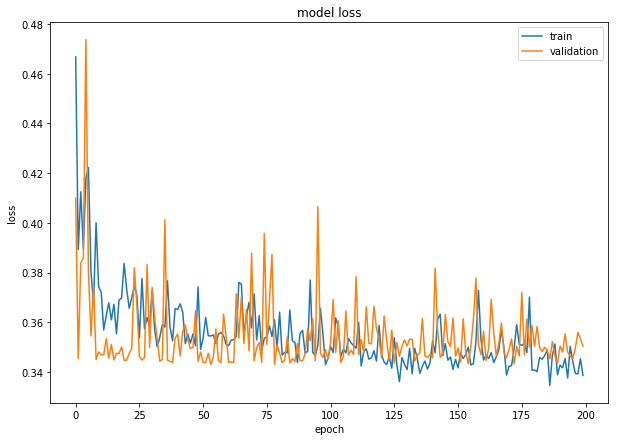

In [18]:
# summarize history for loss
plt.figure(figsize=(10,7))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

### <span style="color:brown">Predicting the trend using the best DNN model</span>

In [19]:
predict_trend=np.ones(len(X_test))
for i in range(X_test.shape[0]):    
    predict_trend[i]=np.where(best_model.predict(np.expand_dims(X_test[i],axis=0))[0][0]>0.5,1,-1)
predict_trend=np.reshape(predict_trend,(1,-1)).tolist()[0]
Y_test=np.where(y_test==0,-1,1)

# Let us check the accuracy of the model on the test data
from sklearn.metrics import accuracy_score

acc= accuracy_score(list(Y_test),list(predict_trend))

In [20]:
print("The Accuracy of the model on the test set is:",acc*100,'%')
print("\n\n\nThe Signals Predicted\n",list(predict_trend))

The Accuracy of the model on the test set is: 69.0 %



The Signals Predicted
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0]


### <span style="color:brown">Comparing the startegy results</span>

Now, let us plot the performance of the model on the test data by multiplying the buy and sell signals with the corresponding future returns.

Once we calculate the percentage returns of the model, we will take a cumulative sum of all these returns on the test data to measure the overall performance of the model.


We have also plotted the cumulative markets returns to compare how a simple Buy and Hold strategy would have performed in comparison to our model.

The annualized interest rate in India is currently 6%. So, for the 100-day period in the test data, the interest rate would be adjusted.

In [21]:
market_returns=pd.Series(data.Last.shift(-1).iloc[-test_size:].pct_change().values)
strategy_returns=pd.Series(predict_trend*market_returns)
intrest_rate=0.06/3
Sharpe=(np.nansum(strategy_returns)-intrest_rate)/strategy_returns.std()
Sharpe

15.714701599295802

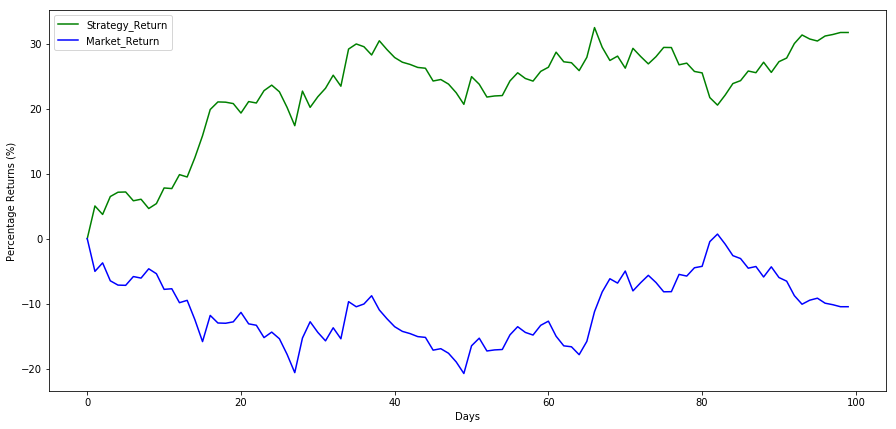

In [22]:
plt.figure(figsize=(15,7))
plt.plot(np.nancumsum(strategy_returns)*100,c='g')
plt.plot(np.nancumsum(market_returns)*100,c='b')
plt.ylabel('Percentage Returns (%)')
plt.xlabel('Days')
plt.legend(['Strategy_Return','Market_Return'])
plt.show()

### <span style="color:brown">Final startegy results</span>

In the past 100 days, the model has returned (%)

In [23]:
final_return=np.nansum(strategy_returns)*100
final_return

31.734775731586907

### <span style="color:brown">Conclusion</span>

In this section, we have learnt how to use the cross validation technique to arrive at the best possible hyper-parameters for a DNN archietecture. Although this process is time taking, it will save you the effort involved in manually tuning all the hyper parameters to arrive at the best possible combination. We hope you have thoroughly enjoyed this course, and look forward to seeing you soon on the Quantra portal.